<a href="https://colab.research.google.com/github/WilliamAshbee/splineexample/blob/main/LSTM_attention_memory_regressor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

x0_y0_r_xrf_yrf torch.Size([100, 1]) torch.Size([100, 1]) torch.Size([100, 1000]) torch.Size([1, 1000]) torch.Size([1, 1000])


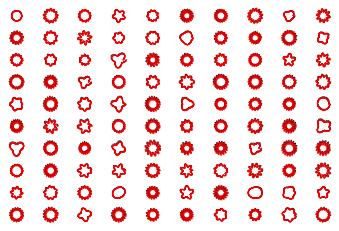

In [1]:
import torch
import numpy as np
import pylab as plt
from skimage import filters
import math

global numpoints
numpoints = 1000
side = 32

rows = torch.zeros(32,32)
columns = torch.zeros(32,32)


for i in range(32):
    columns[:,i] = i
    rows[i,:] = i


def donut_matrix(length = 10):
    radiusMax = side /3
    w = 1
    sigmas = [None, 1]
    
    canvas = torch.zeros((length,side, side))
    r0 = torch.tensor(np.random.uniform(side/4, side/3, length))

    radii = torch.zeros((length,numpoints))
    radii[:, :] = r0.unsqueeze(1)
    
    ind = [x for x in range(numpoints)]

    theta = torch.FloatTensor(ind)
    theta *= math.pi*2.0/(float)(numpoints)
    
    for i in range(1,length):
        a = np.random.uniform(1.0,3.0)*torch.sin(np.random.uniform(20.0)*theta+np.random.uniform(1000.0))
        #a = 4.0*torch.sin(10.0*theta)
        #print(a.shape,torch.max(a))
        radii[i,:] += a
        #print(radii.shape, torch.max(radii))
    
    assert torch.min(radii)>0
    #print(radii.max(axis = 0)[0].shape)
    rmaxs = radii.max(axis = 1)[0]
    pmins = rmaxs+1.0
    pmaxs = side-rmaxs-1.0
    x0 = np.random.uniform(pmins,pmaxs)
    y0 = np.random.uniform(pmins,pmaxs)
    x0[:]=side/2
    y0[:]=side/2
    x0 = torch.tensor(x0)
    y0 = torch.tensor(y0)
    
    x0 = x0.unsqueeze(1)
    y0 = y0.unsqueeze(1)
    #radii = torch.from_numpy(radii)
    xrfactors = torch.cos(theta).unsqueeze(0)
    yrfactors = torch.sin(theta).unsqueeze(0)
    
    print('x0_y0_r_xrf_yrf',x0.shape,y0.shape,radii.shape,xrfactors.shape,yrfactors.shape)

    x = (x0+(xrfactors*radii))
    y = (y0+(yrfactors*radii))
    assert x.shape == (length,numpoints)
    assert y.shape == (length,numpoints)
    assert torch.sum(x[x>(side-1)])==0 
    assert torch.sum(x[x<0])==0 
    assert torch.sum(y[y>(side-1)])==0 
    assert torch.sum(y[y<0])==0 
    
    points = torch.zeros(length,numpoints,2)
    for l in range(length):
        canvas[l,y[l,:].type(torch.LongTensor),x[l,:].type(torch.LongTensor)]=1.0
        points[l,:,0] = x[l,:]#modified for lstm discriminator
        points[l,:,1] = y[l,:]#modified for lstm discriminator 
    
    
    return {
        'canvas': canvas, 
        'points':points.type(torch.FloatTensor)}


def plot_all( sample = None, model = None, labels = None):
    img = sample[:,:].squeeze().cpu().numpy()
    #img = img.T
    plt.imshow(img, cmap=plt.cm.gray_r)
    if model != None:
        with torch.no_grad():
            global numpoints
            print(labels.shape,sample.shape)
            sample = torch.stack([sample for i in range(2)],dim = 0).cuda()
            labels = torch.stack([labels for i in range(2)],dim = 0).cuda()
            pred = model(sample.cuda(),labels.cuda())#come back to this
            predres = numpoints
            print('pred',pred.shape)
            X = pred[0,:,0]
            Y = pred[0,:,1]
            
            s = [.001 for x in range(predres)]
            
            assert len(s) == predres
            c = ['red' for x in range(predres)]
            assert len(c) == predres
            Y = Y.cuda()
            X = X.cuda()
            #print("type",type(X))
            ascatter = plt.scatter(X.cpu().numpy(),Y.cpu().numpy(),s = s,c = c)
            plt.gca().add_artist(ascatter)
    else:
        #print(labels.shape)
        X = labels[:,0]
        Y = labels[:,1]
        #print(X.shape)
        #print(Y.shape)
        s = [.001 for x in range(numpoints)]
        #print(len(s))
        c = ['red' for x in range(numpoints)]
        #print(len(c))
        ascatter = plt.scatter(X.cpu().numpy(),Y.cpu().numpy(),s = s,c = c)
        plt.gca().add_artist(ascatter)

class DonutDataset(torch.utils.data.Dataset):
    """Donut dataset."""
    def __init__(self, length = 10):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.length = length
        self.values = donut_matrix(length)
        assert self.values['canvas'].shape[0] == self.length
        assert self.values['points'].shape[0] == self.length
        
        count = 0
        for i in range(self.length):
          a = self[i]
          c = a[0]
          for el in a[1]:
            #print(c[(int)(el[1]),(int)(el[0])].item())
            #assert c[(int)(el[1]),(int)(el[0])].item() == 1
            y,x = (int)(el[1]),(int)(el[0])
            if x < side-2 and x > 2 and y < side-2 and y > 2: 
              if c[y,x] != 1 and \
                c[y+1,x] != 1 and c[y+1,-1+x] != 1 and c[y+1,1+x] != 1 and \
                c[y-1,x] != 1 and c[y,-1+x] != 1 and c[y,1+x] != 1:
                count+=1
        assert count ==0
    def __len__(self):
        return self.length


    def __getitem__(self, idx):
        canvas = self.values["canvas"]
        
        canvas = canvas[idx,:,:]
        assert canvas.shape == (side,side)
        
        points = self.values["points"]
        points = points[idx,:]
        #points = points.unsqueeze(1)
        z = torch.zeros(numpoints,1)
        #print(z.shape)
        points = torch.cat([points,z], dim = 1)
        
        #print('points', points.shape)
        return canvas, points
    
    @staticmethod
    def displayCanvas(title,dataset, model):
        #model.setBatchSize(batch_size = 1)
        for i in range(100):
            sample, labels = dataset[i]
            plt.subplot(10,10,i+1)
            plot_all(sample = sample,model=model, labels = labels)
            plt.axis('off')
        plt.savefig(title,dpi=600)

dataset = DonutDataset(length = 100)

DonutDataset.displayCanvas('donut.png',dataset, model = None)


In [2]:

from torch.utils import data
from torch.utils.data import DataLoader, TensorDataset, RandomSampler

mini_batch = 64
test_dataset = DonutDataset(length = 64)
loader_test = data.DataLoader(
    test_dataset, 
    batch_size=mini_batch,
    sampler=RandomSampler(data_source=test_dataset),
    num_workers=4)


x0_y0_r_xrf_yrf torch.Size([64, 1]) torch.Size([64, 1]) torch.Size([64, 1000]) torch.Size([1, 1000]) torch.Size([1, 1000])


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [3]:

from torch.utils import data
from torch.utils.data import DataLoader, TensorDataset, RandomSampler

mini_batch = 64
dataset = DonutDataset(length = 64*20)
loader_train = data.DataLoader(
    dataset, 
    batch_size=mini_batch,
    sampler=RandomSampler(data_source=dataset),
    num_workers=4)


x0_y0_r_xrf_yrf torch.Size([1280, 1]) torch.Size([1280, 1]) torch.Size([1280, 1000]) torch.Size([1, 1000]) torch.Size([1, 1000])


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


I think I need to give the model the first x0,y0 coordinate in addition to all the other information.

Ablation:\
Network depth helps\
Network width helps\
Probably lower learning rate and long running times helps \
\
note:\
worth noting one of the ameba columns always starts at the same place

In [184]:
import torch
import torch.nn as nn
from torch.hub import load_state_dict_from_url

class DecoderRNN(nn.Module):
    def __init__(self):
        super(DecoderRNN, self).__init__()
        self.track = 0
        # define the properties
        self.embed_size = 2
        self.hidden_size = 256
        self.num_layers = 2
        self.seq_len = 50
        self.longtermMem = None
        self.longtermMemP = None
        # lstm cell
        self.lstm_cell = nn.LSTM(2, self.hidden_size,self.num_layers)

        self.embedimage = nn.Sequential(
            nn.Linear(1024+self.hidden_size,256),
            nn.ReLU()
        )

        
        self.fc_out = nn.Sequential(
            nn.Linear(20*self.hidden_size+20*self.embed_size+self.hidden_size*3+4,2),
            nn.Sigmoid()
        )
        self.alpha = nn.Sequential(
            nn.Linear(self.seq_len*self.hidden_size,50),
            nn.Softmax()
        )
        


        self.hiddenMlp = nn.Sequential(
            nn.Linear(1024+2,self.hidden_size),nn.ReLU())
        self.cellMlp = nn.Sequential(
            nn.Linear(1024+2,self.hidden_size),nn.ReLU())
        

            
        
    def forward(self, features, captions,h0 = None, c0= None,ind = 0):

        
        self.track +=1
        batch_size = features.size(0)
        if h0 == None:
          self.longtermMem = torch.zeros((batch_size,  self.hidden_size,20)).cuda()
          self.longtermMemP = torch.zeros(((batch_size,  self.embed_size,20))).cuda()
        else:
          self.longtermMem = self.longtermMem.detach()
          self.longtermMemP = self.longtermMemP.detach()
        

        img_emb = torch.empty((batch_size, captions.size(1), self.hidden_size)).cuda()
        
        p0 = torch.flatten(captions[:,0,:2],start_dim=1)
        out = p0

                
        if h0 == None or c0 == None:
          h0 = torch.zeros(1,batch_size, self.hidden_size).cuda()
          c0 = torch.zeros(1,batch_size, self.hidden_size).cuda()
        
        #  h0 = self.hiddenMlp(torch.cat([torch.flatten(features,start_dim=1),p0],dim=1)).reshape(1,batch_size, self.hidden_size)
        #  c0 = self.cellMlp(torch.cat([torch.flatten(features,start_dim=1),p0],dim=1)).reshape(1,batch_size, self.hidden_size)
        
        if self.num_layers>1 and h0.shape[0] == 1:
          h0 = torch.stack([h0.squeeze() for i in range(self.num_layers)],dim = 0)
          c0 = torch.stack([c0.squeeze() for i in range(self.num_layers)],dim = 0)
        
        #print(h0.shape)
        
        outputs = torch.empty((batch_size, captions.size(1), 2)).cuda()
        
        
        for t in range(captions.size(1)):
        
            # for the first time step the input is the feature vector
            if t == 0:
                #inp = self.embedimageFP(
                #    torch.cat([torch.flatten(features,start_dim=1),p0],dim=1))
                #print(inp.shape,p0.shape)
                output, (hidden_state, cell_state) = self.lstm_cell(p0.unsqueeze(0), (h0, c0))
            else:
                #inp = self.embedimageFP(
                #    torch.cat([torch.flatten(features,start_dim=1),out],dim=1))
                #print(inp.shape, out.shape
                output, (hidden_state, cell_state) = self.lstm_cell(out.unsqueeze(0), (hidden_state, cell_state))
                
                
            assert h0 != None

            #print(features.shape, output.shape)
            
            emb = self.embedimage(torch.cat([torch.flatten(features,start_dim=1),output.squeeze()],dim=1))
            if t ==0:
              self.longtermMem[:,:,i]=emb
            img_emb[:, t, :] = emb
            
            #print('emb',emb.shape)
            
            alph = self.alpha(torch.flatten(img_emb.clone(),start_dim=1))
            if self.track % 50 == 0:
              print(torch.max(alph),t, torch.argmax(alph))
            #print('alpha',alph.shape)
            outesalpha = img_emb.clone()*alph.unsqueeze(2)
            
            outefl = torch.sum(outesalpha,dim=1)
            combOut = torch.cat([torch.flatten(self.longtermMemP,start_dim=1),torch.flatten(self.longtermMem,start_dim=1),outefl,img_emb[:, 0, :],emb,p0,out],dim=1)
            
            out = self.fc_out(combOut)
            if t ==0:
              #print(out.shape,self.longtermMemP.shape)

              self.longtermMemP[:,:,i]=out
            
            # build the output tensor
            
            
            
            
            
            #alph = self.alpha(torch.flatten(outes.clone(),start_dim=1))
            
            outputs[:, t, :] = out
        #print(h0.shape,hidden_state.shape)
            
        return 32.0*outputs, hidden_state.detach().clone(), cell_state.detach().clone()#, captions

In [185]:
a = torch.ones(64,256,50)
b = torch.from_numpy(np.random.randn(50))
c = a*b
print(c[0,1,:])
print(c[1,1,:])

tensor([-9.8784e-02,  2.1213e+00,  1.0228e+00, -3.6943e-01, -1.2657e-01,
        -1.3481e-01,  1.3765e+00,  5.9723e-02,  1.9968e-01,  3.4299e-01,
         2.3507e-01,  8.8169e-01, -8.9200e-01,  6.2233e-02,  1.9807e-03,
         1.5536e+00,  6.7771e-01, -1.3176e+00, -3.2383e-01, -1.7298e+00,
        -7.5236e-01,  1.6744e-01,  1.6875e-01, -2.0444e+00, -9.3230e-01,
         6.9173e-01,  1.0955e-01,  1.8926e-01, -7.5597e-02, -5.0569e-02,
         6.1402e-02, -5.0170e-01, -3.6202e-01, -2.3551e-01,  3.3914e-01,
        -3.9869e-01,  2.7926e-03, -3.2698e-01, -6.3405e-01,  8.9879e-01,
        -4.8978e-02, -1.6325e+00, -3.3974e-01, -3.1706e-01, -6.6011e-01,
        -2.4841e-01,  5.5357e-01,  7.2305e-01,  1.6175e+00,  2.3151e+00],
       dtype=torch.float64)
tensor([-9.8784e-02,  2.1213e+00,  1.0228e+00, -3.6943e-01, -1.2657e-01,
        -1.3481e-01,  1.3765e+00,  5.9723e-02,  1.9968e-01,  3.4299e-01,
         2.3507e-01,  8.8169e-01, -8.9200e-01,  6.2233e-02,  1.9807e-03,
         1.5536e+00,  

In [186]:
model = DecoderRNN().cuda()

In [187]:
optimizer = torch.optim.Adam(model.parameters(),lr = 0.0001, betas = (.9,.999))#ideal


In [188]:
import torch
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()


In [189]:
model = model.train()
for epoch in range (20):
  loss = None
  for x,y in loader_train:
    h0 = None
    c0 = None
    for i in range(19):
      x = x.cuda()
      y = y.cuda()
      
      optimizer.zero_grad()
      #print(x.shape,y.shape)

      out, h0, c0 = model(x,y[:,i*50:50*(i+1),:2],h0,c0,i)
      loss = torch.mean((out-y[:,1+(50*i):1+(50*(i+1)),:2])**2)
      writer.add_scalar("Loss/train", loss, epoch)

      loss.backward()
      optimizer.step()
    #print(y[:,0,:2])
    print('epoch',epoch)
    print(loss)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:119: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Streaming output truncated to the last 5000 lines.
tensor(1., device='cuda:0', grad_fn=<MaxBackward1>) 24 tensor(3061, device='cuda:0')
tensor(1., device='cuda:0', grad_fn=<MaxBackward1>) 25 tensor(3061, device='cuda:0')
tensor(1., device='cuda:0', grad_fn=<MaxBackward1>) 26 tensor(3061, device='cuda:0')
tensor(1., device='cuda:0', grad_fn=<MaxBackward1>) 27 tensor(3061, device='cuda:0')
tensor(1., device='cuda:0', grad_fn=<MaxBackward1>) 28 tensor(3061, device='cuda:0')
tensor(1., device='cuda:0', grad_fn=<MaxBackward1>) 29 tensor(3061, device='cuda:0')
tensor(1., device='cuda:0', grad_fn=<MaxBackward1>) 30 tensor(3061, device='cuda:0')
tensor(1., device='cuda:0', grad_fn=<MaxBackward1>) 31 tensor(3061, device='cuda:0')
tensor(1., device='cuda:0', grad_fn=<MaxBackward1>) 32 tensor(3061, device='cuda:0')
tensor(1., device='cuda:0', grad_fn=<MaxBackward1>) 33 tensor(3061, device='cuda:0')
tensor(1., device='cuda:0', grad_fn=<MaxBackward1>) 34 tensor(3061, device='cuda:0')
tensor(1., dev

In [190]:
optimizer = torch.optim.Adam(model.parameters(),lr = 0.00001, betas = (.9,.999))#ideal


In [191]:
model = model.train()
for epoch in range (20):
  loss = None
  for x,y in loader_train:
    h0 = None
    c0 = None
    for i in range(19):
      x = x.cuda()
      y = y.cuda()
      
      optimizer.zero_grad()
      #print(x.shape,y.shape)

      out, h0, c0 = model(x,y[:,i*50:50*(i+1),:2],h0,c0)
      loss = torch.mean((out-y[:,1+(50*i):1+(50*(i+1)),:2])**2)
      writer.add_scalar("Loss/train", loss, epoch)

      loss.backward()
      optimizer.step()
    #print(y[:,0,:2])
    print('epoch',epoch)
    print(loss)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:119: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Streaming output truncated to the last 5000 lines.
tensor(1., device='cuda:0', grad_fn=<MaxBackward1>) 24 tensor(3061, device='cuda:0')
tensor(1., device='cuda:0', grad_fn=<MaxBackward1>) 25 tensor(3061, device='cuda:0')
tensor(1., device='cuda:0', grad_fn=<MaxBackward1>) 26 tensor(3061, device='cuda:0')
tensor(1., device='cuda:0', grad_fn=<MaxBackward1>) 27 tensor(3061, device='cuda:0')
tensor(1., device='cuda:0', grad_fn=<MaxBackward1>) 28 tensor(3061, device='cuda:0')
tensor(1., device='cuda:0', grad_fn=<MaxBackward1>) 29 tensor(3061, device='cuda:0')
tensor(1., device='cuda:0', grad_fn=<MaxBackward1>) 30 tensor(3061, device='cuda:0')
tensor(1., device='cuda:0', grad_fn=<MaxBackward1>) 31 tensor(3061, device='cuda:0')
tensor(1., device='cuda:0', grad_fn=<MaxBackward1>) 32 tensor(3061, device='cuda:0')
tensor(1., device='cuda:0', grad_fn=<MaxBackward1>) 33 tensor(3061, device='cuda:0')
tensor(1., device='cuda:0', grad_fn=<MaxBackward1>) 34 tensor(3061, device='cuda:0')
tensor(1.0000,

In [ ]:
optimizer = torch.optim.Adam(model.parameters(),lr = 0.000001, betas = (.9,.999))#ideal


In [ ]:
model = model.train()
for epoch in range (20):
  loss = None
  for x,y in loader_train:
    h0 = None
    c0 = None
    for i in range(19):
      x = x.cuda()
      y = y.cuda()
      
      optimizer.zero_grad()
      #print(x.shape,y.shape)

      out, h0, c0 = model(x,y[:,i*50:50*(i+1),:2],h0,c0)
      loss = torch.mean((out-y[:,1+(50*i):1+(50*(i+1)),:2])**2)
      writer.add_scalar("Loss/train", loss, epoch)

      loss.backward()
      optimizer.step()
    #print(y[:,0,:2])
    print('epoch',epoch)
    print(loss)

In [193]:
from torch.utils import data
from torch.utils.data import DataLoader, TensorDataset, RandomSampler

mini_batch = 64
test_dataset = DonutDataset(length = 64)
loader_test = data.DataLoader(
    test_dataset, 
    batch_size=mini_batch,
    sampler=RandomSampler(data_source=test_dataset),
    num_workers=4)


x0_y0_r_xrf_yrf torch.Size([64, 1]) torch.Size([64, 1]) torch.Size([64, 1000]) torch.Size([1, 1000]) torch.Size([1, 1000])


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [197]:
model = model.eval()
for epoch in range (1):
  loss = None
  for x,y in loader_test:
    h0 = None
    c0 = None
    loss = torch.zeros(19)
    for i in range(19):
      x = x.cuda()
      y = y.cuda()
      
      #print(x.shape,y.shape)

      out, h0, c0 = model(x,y[:,i*50:50*(i+1),:2],h0,c0)
      
      loss[i] = torch.mean((out-y[:,1+(50*i):1+(50*(i+1)),:2])**2)
      print(loss[i])
      writer.add_scalar("Loss/val", loss[i],i, epoch)

    #print(y[:,0,:2])
    print('epoch',epoch)
    print('test loss', torch.mean(loss))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:119: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


tensor(0.8086, grad_fn=<SelectBackward>)
tensor(0.9587, grad_fn=<SelectBackward>)
tensor(0.8879, grad_fn=<SelectBackward>)
tensor(0.9120, grad_fn=<SelectBackward>)
tensor(0.7777, grad_fn=<SelectBackward>)
tensor(0.7697, grad_fn=<SelectBackward>)
tensor(0.6752, grad_fn=<SelectBackward>)
tensor(0.6406, grad_fn=<SelectBackward>)
tensor(0.5929, grad_fn=<SelectBackward>)
tensor(0.6552, grad_fn=<SelectBackward>)
tensor(0.0599, device='cuda:0', grad_fn=<MaxBackward1>) 0 tensor(2250, device='cuda:0')
tensor(0.1731, device='cuda:0', grad_fn=<MaxBackward1>) 1 tensor(2250, device='cuda:0')
tensor(0.2157, device='cuda:0', grad_fn=<MaxBackward1>) 2 tensor(2799, device='cuda:0')
tensor(0.2180, device='cuda:0', grad_fn=<MaxBackward1>) 3 tensor(2799, device='cuda:0')
tensor(0.1884, device='cuda:0', grad_fn=<MaxBackward1>) 4 tensor(2799, device='cuda:0')
tensor(0.1600, device='cuda:0', grad_fn=<MaxBackward1>) 5 tensor(2799, device='cuda:0')
tensor(0.1388, device='cuda:0', grad_fn=<MaxBackward1>) 6 tens

In [198]:
writer.flush()
writer.close()


**started** with .0001 then moved to .00001 learning rate (20 epochs) 
finished with .000001 lr, but didn't see much more improvement (total 60 epochs 20,20,20) extra 20 over previous comment

In [ ]:
#%load_ext tensorboard

In [ ]:
#!kill 3285
#%tensorboard --logdir runs